## UNET For Salt Identification

In [1]:
## Libraries

import os
import numpy as np
import random

from tqdm.notebook import tqdm

from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.optimizers import Adam
from keras import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, \
                         concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [2]:
## Config
DATA_IMAGES = "dataset/train/images"
DATA_MASKS = "dataset/train/masks"
IM_HEIGHT = 128
IM_WIDTH = 128
IMG_IDS = next(os.walk(DATA_IMAGES))[2]
print("---"*20)
print(f"No of images in the dataset: {len(IMG_IDS)}")
print("---"*20)


------------------------------------------------------------
No of images in the dataset: 4000
------------------------------------------------------------


In [3]:
## Get empty numpy arrays
X = np.zeros((len(IMG_IDS), IM_HEIGHT, IM_WIDTH, 1), dtype=np.float32)
y = np.zeros((len(IMG_IDS), IM_HEIGHT, IM_WIDTH, 1), dtype=np.float32)

In [4]:
def create_labelled_dataset():
   
    for n, ids in enumerate(tqdm(IMG_IDS)):        
        img = load_img(os.path.join(DATA_IMAGES, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (IM_HEIGHT, IM_WIDTH, 1), mode='constant', preserve_range=True)
        
        mask  = load_img(os.path.join(DATA_MASKS, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (IM_HEIGHT, IM_WIDTH, 1), mode='constant', preserve_range=True)
        
        X[n] = x_img/255.0 
        y[n] = y_mask/255.0
        
    return X, y

In [5]:
X, y = create_labelled_dataset()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
## Train and Validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Random Sample Index is: 1860


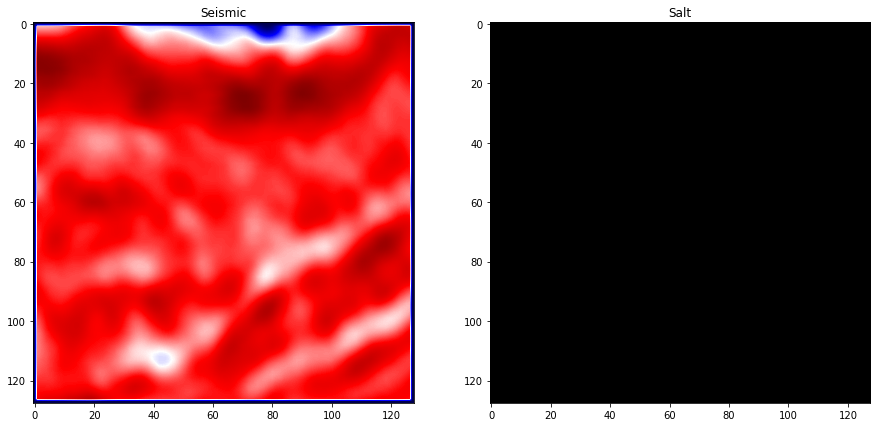

In [7]:
## Plotting Sample Data

def plot_sample_example():
    ix = random.randint(0, len(X_train))
    print(f"Random Sample Index is: {ix}")
    has_mask = y_train[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')

    ## If there is a mask
    if has_mask:
        ax1.contour(y_train[ix].squeeze(), colors = 'black', linewidths = 3, levels = [0.5])
    ax1.set_title('Seismic')

    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Salt')
    
plot_sample_example()

## Modelling

In [8]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers"""
    ## Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
              kernel_initializer='he_normal', padding='same')(input_tensor)
    ## batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    ## Activation
    x = Activation('relu')(x)
        
    ## Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
               kernel_initializer='he_normal', padding='same')(x)
    ## batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    ## Activation
    x = Activation('relu')(x)
    
    return x

In [9]:
## Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    ## Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)
    
    ## Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
   
    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
   
    ## final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [10]:
## Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 1), name='img')
model = unet(input_img, n_filters=16, kernel_size=3, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
## Call Backs
call_backs = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=call_backs, \
                   validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - 193s 2s/step - loss: 0.4382 - accuracy: 0.7050 - val_loss: 21.8862 - val_accuracy: 0.0015

Epoch 00001: val_loss improved from inf to 21.88622, saving model to model-unet-salt.h5
Epoch 2/50
113/113 [==============================] - 204s 2s/step - loss: 0.3019 - accuracy: 0.7335 - val_loss: 0.7378 - val_accuracy: 0.5555

Epoch 00002: val_loss improved from 21.88622 to 0.73782, saving model to model-unet-salt.h5
Epoch 3/50
113/113 [==============================] - 211s 2s/step - loss: 0.2868 - accuracy: 0.7262 - val_loss: 0.3926 - val_accuracy: 0.6216

Epoch 00003: val_loss improved from 0.73782 to 0.39260, saving model to model-unet-salt.h5
Epoch 4/50
113/113 [==============================] - 219s 2s/step - loss: 0.2616 - accuracy: 0.7282 - val_loss: 0.2932 - val_accuracy: 0.6920

Epoch 00004: val_loss improved from 0.39260 to 0.29320, saving model to model-unet-salt.h5
Epoch 5/50
110/113 [============================>.] - ETA: 5s

In [ ]:

def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

    
plot_history(results)

## Inference

In [ ]:
model.load_weights('model-unet-salt.h5')

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample_results(X, y, preds, binary_preds):
    ix = random.randint(0, len(X))
    
    has_mask = y[ix].max() > 0
    
    fig, ax = plt.subplots(1, 4, figsize=(20,10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')

    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sesimic')
    
    ax[1].imshow(y[ix])
    ax[1].set_title('Salt')
    
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted Binary') ;

In [ ]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

In [ ]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

In [ ]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

In [ ]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

In [ ]:
## Predictions on Training Set
plot_sample_results(X_train, y_train, preds_train, preds_train_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
## Predictions on Test Set
plot_sample_results(X_valid, y_valid, preds_val, preds_val_t)